##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using the SavedModel format

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/saved_model"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/saved_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/saved_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/saved_model.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

A SavedModel contains a complete TensorFlow program, including trained parameters (i.e, `tf.Variable`s) and computation. It does not require the original model building code to run, which makes it useful for sharing or deploying with [TFLite](https://tensorflow.org/lite), [TensorFlow.js](https://js.tensorflow.org/), [TensorFlow Serving](https://www.tensorflow.org/tfx/serving/tutorials/Serving_REST_simple), or [TensorFlow Hub](https://tensorflow.org/hub).

You can save and load a model in the SavedModel format using the following APIs:
- Low-level `tf.saved_model` API. This document describes how to use this API in detail.
 - Save: `tf.saved_model.save(model, path_to_dir)`
 - Load: `model = tf.saved_model.load(path_to_dir)`
- High-level `tf.keras.Model` API. Refer to [the keras save and serialize guide](https://www.tensorflow.org/guide/keras/save_and_serialize).
- If you just want to save/load weights during training, refer to [the checkpoints guide](./checkpoint.ipynb).

Caution: TensorFlow models are code and it is important to be careful with untrusted code. Learn more in [Using TensorFlow securely](https://github.com/tensorflow/tensorflow/blob/master/SECURITY.md).


## Creating a SavedModel from Keras

Deprecated: For Keras objects, it's recommended to use the new high-level `.keras` format and `tf.keras.Model.export`, as demonstrated in the guide [here](https://www.tensorflow.org/guide/keras/save_and_serialize). The low-level SavedModel format continues to be supported for existing code.

For a quick introduction, this section exports a pre-trained Keras model and serves image classification requests with it. The rest of the guide will fill in details and discuss other ways to create SavedModels.

In [1]:
import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

tmpdir = tempfile.mkdtemp()

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

61306/61306 [==============================] - 0s 0us/step


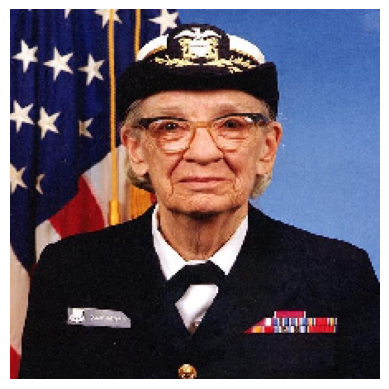

In [3]:
file = tf.keras.utils.get_file(
    "grace_hopper.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")
img = tf.keras.utils.load_img(file, target_size=[224, 224])
plt.imshow(img)
plt.axis('off')
x = tf.keras.utils.img_to_array(img)
x = tf.keras.applications.mobilenet.preprocess_input(
    x[tf.newaxis,...])

You'll use an image of Grace Hopper as a running example, and a Keras pre-trained image classification model since it's easy to use. Custom models work too, and are covered in detail later.

In [4]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


In [5]:
pretrained_model = tf.keras.applications.MobileNet()
result_before_save = pretrained_model(x)

decoded = imagenet_labels[np.argsort(result_before_save)[0,::-1][:5]+1]

print("Result before saving:\n", decoded)

17225924/17225924 [==============================] - 0s 0us/step
Result before saving:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube']


The top prediction for this image is "military uniform".

In [6]:
mobilenet_save_path = os.path.join(tmpdir, "mobilenet/1/")
tf.saved_model.save(pretrained_model, mobilenet_save_path)

The save-path follows a convention used by TensorFlow Serving where the last path component (`1/` here) is a version number for your model - it allows tools like Tensorflow Serving to reason about the relative freshness.

You can load the SavedModel back into Python with `tf.saved_model.load` and see how Admiral Hopper's image is classified.

In [7]:
loaded = tf.saved_model.load(mobilenet_save_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


Imported signatures always return dictionaries. To customize signature names and output dictionary keys, see [Specifying signatures during export](#specifying_signatures_during_export).

In [8]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}


Running inference from the SavedModel gives the same result as the original model.

In [9]:
labeling = infer(tf.constant(x))[pretrained_model.output_names[0]]

decoded = imagenet_labels[np.argsort(labeling)[0,::-1][:5]+1]

print("Result after saving and loading:\n", decoded)

Result after saving and loading:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube']


## Running a SavedModel in TensorFlow Serving

SavedModels are usable from Python (more on that below), but production environments typically use a dedicated service for inference without running Python code. This is easy to set up from a SavedModel using TensorFlow Serving.

See the [TensorFlow Serving REST tutorial](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple) for an end-to-end tensorflow-serving example.

## The SavedModel format on disk

A SavedModel is a directory containing serialized signatures and the state needed to run them, including variable values and vocabularies.


In [10]:
!ls {mobilenet_save_path}

assets	fingerprint.pb	saved_model.pb	variables


The `saved_model.pb` file stores the actual TensorFlow program, or model, and a set of named signatures, each identifying a function that accepts tensor inputs and produces tensor outputs.

SavedModels may contain multiple variants of the model (multiple `v1.MetaGraphDefs`, identified with the `--tag_set` flag to `saved_model_cli`), but this is rare. APIs which create multiple variants of a model include [`tf.Estimator.experimental_export_all_saved_models`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator#experimental_export_all_saved_models) and in TensorFlow 1.x `tf.saved_model.Builder`.

In [11]:
!saved_model_cli show --dir {mobilenet_save_path} --tag_set serve

2023-08-28 07:31:32.391298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


The `variables` directory contains a standard training checkpoint (see the [guide to training checkpoints](./checkpoint.ipynb)).

In [12]:
!ls {mobilenet_save_path}/variables

variables.data-00000-of-00001  variables.index


The `assets` directory contains files used by the TensorFlow graph, for example text files used to initialize vocabulary tables. It is unused in this example.

SavedModels may have an `assets.extra` directory for any files not used by the TensorFlow graph, for example information for consumers about what to do with the SavedModel. TensorFlow itself does not use this directory.

The `fingerprint.pb` file contains the [fingerprint](https://en.wikipedia.org/wiki/Fingerprint_(computing)) of the SavedModel, which is composed of several 64-bit hashes that uniquely identify the contents of the SavedModel. The fingerprinting API is currently experimental, but `tf.saved_model.experimental.read_fingerprint` can be used to read the SavedModel fingerprint into a `tf.saved_model.experimental.Fingerprint` object.

## Saving a custom model

`tf.saved_model.save` supports saving `tf.Module` objects and its subclasses, like `tf.keras.Layer` and `tf.keras.Model`.

Let's look at an example of saving and restoring a `tf.Module`.


In [13]:
class CustomModule(tf.Module):

  def __init__(self):
    super(CustomModule, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function
  def __call__(self, x):
    print('Tracing with', x)
    return x * self.v

  @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
  def mutate(self, new_v):
    self.v.assign(new_v)

module = CustomModule()

When you save a `tf.Module`, any `tf.Variable` attributes, `tf.function`-decorated methods, and `tf.Module`s found via recursive traversal are saved. (See the [Checkpoint tutorial](./checkpoint.ipynb) for more about this recursive traversal.) However, any Python attributes, functions, and data are lost. This means that when a `tf.function` is saved, no Python code is saved.

If no Python code is saved, how does SavedModel know how to restore the function?

Briefly, `tf.function` works by tracing the Python code to generate a ConcreteFunction (a callable wrapper around `tf.Graph`). When saving a `tf.function`, you're really saving the `tf.function`'s cache of ConcreteFunctions.

To learn more about the relationship between `tf.function` and ConcreteFunctions, refer to the [tf.function guide](function.ipynb).

In [14]:
module_no_signatures_path = os.path.join(tmpdir, 'module_no_signatures')
module(tf.constant(0.))
print('Saving model...')
tf.saved_model.save(module, module_no_signatures_path)

Tracing with Tensor("x:0", shape=(), dtype=float32)
Saving model...
Tracing with Tensor("x:0", shape=(), dtype=float32)


## Loading and using a custom model

When you load a SavedModel in Python, all `tf.Variable` attributes, `tf.function`-decorated methods, and `tf.Module`s are restored in the same object structure as the original saved `tf.Module`.

In [15]:
imported = tf.saved_model.load(module_no_signatures_path)
assert imported(tf.constant(3.)).numpy() == 3
imported.mutate(tf.constant(2.))
assert imported(tf.constant(3.)).numpy() == 6

Because no Python code is saved, calling a `tf.function` with a new input signature will fail:

```python
imported(tf.constant([3.]))
```

<pre>
ValueError: Could not find matching function to call for canonicalized inputs ((<tf.Tensor 'args_0:0' shape=(1,) dtype=float32>,), {}). Only existing signatures are [((TensorSpec(shape=(), dtype=tf.float32, name=u'x'),), {})].
</pre>

### Basic fine-tuning

Variable objects are available, and you can backprop through imported functions. That is enough to fine-tune (i.e. retrain) a SavedModel in simple cases.

In [16]:
optimizer = tf.keras.optimizers.SGD(0.05)

def train_step():
  with tf.GradientTape() as tape:
    loss = (10. - imported(tf.constant(2.))) ** 2
  variables = tape.watched_variables()
  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))
  return loss

In [17]:
for _ in range(10):
  # "v" approaches 5, "loss" approaches 0
  print("loss={:.2f} v={:.2f}".format(train_step(), imported.v.numpy()))

loss=36.00 v=3.20
loss=12.96 v=3.92
loss=4.67 v=4.35
loss=1.68 v=4.61
loss=0.60 v=4.77
loss=0.22 v=4.86
loss=0.08 v=4.92
loss=0.03 v=4.95
loss=0.01 v=4.97
loss=0.00 v=4.98


### General fine-tuning

A SavedModel from Keras provides [more details](https://github.com/tensorflow/community/blob/master/rfcs/20190509-keras-saved-model.md#serialization-details) than a plain `__call__` to address more advanced cases of fine-tuning. TensorFlow Hub recommends to provide the following of those, if applicable, in SavedModels shared for the purpose of fine-tuning:

  * If the model uses dropout or another technique in which the forward pass differs between training and inference (like batch normalization), the `__call__` method takes an optional, Python-valued `training=` argument that defaults to `False` but can be set to `True`.
  * Next to the `__call__` attribute, there are `.variable` and `.trainable_variable` attributes with the corresponding lists of variables. A variable that was originally trainable but is meant to be frozen during fine-tuning is omitted from `.trainable_variables`.
  * For the sake of frameworks like Keras that represent weight regularizers as attributes of layers or sub-models, there can also be a `.regularization_losses` attribute. It holds a list of zero-argument functions whose values are meant for addition to the total loss.

Going back to the initial MobileNet example, you can see some of those in action:

In [18]:
loaded = tf.saved_model.load(mobilenet_save_path)
print("MobileNet has {} trainable variables: {}, ...".format(
          len(loaded.trainable_variables),
          ", ".join([v.name for v in loaded.trainable_variables[:5]])))

MobileNet has 83 trainable variables: conv1/kernel:0, conv1_bn/gamma:0, conv1_bn/beta:0, conv_dw_1/depthwise_kernel:0, conv_dw_1_bn/gamma:0, ...


In [19]:
trainable_variable_ids = {id(v) for v in loaded.trainable_variables}
non_trainable_variables = [v for v in loaded.variables
                           if id(v) not in trainable_variable_ids]
print("MobileNet also has {} non-trainable variables: {}, ...".format(
          len(non_trainable_variables),
          ", ".join([v.name for v in non_trainable_variables[:3]])))

MobileNet also has 54 non-trainable variables: conv1_bn/moving_mean:0, conv1_bn/moving_variance:0, conv_dw_1_bn/moving_mean:0, ...


## Specifying signatures during export

Tools like TensorFlow Serving and `saved_model_cli` can interact with SavedModels. To help these tools determine which ConcreteFunctions to use, you need to specify serving signatures. `tf.keras.Model`s automatically specify serving signatures, but you'll have to explicitly declare a serving signature for our custom modules.

IMPORTANT: Unless you need to export your model to an environment other than TensorFlow 2.x with Python, you probably don't need to export signatures explicitly. If you're looking for a way of enforcing an input signature for a specific function, see the [`input_signature`](https://www.tensorflow.org/api_docs/python/tf/function#args_1) argument to `tf.function`.

By default, no signatures are declared in a custom `tf.Module`.

In [ ]:
assert len(imported.signatures) == 0

To declare a serving signature, specify a ConcreteFunction using the `signatures` kwarg. When specifying a single signature, its signature key will be `'serving_default'`, which is saved as the constant `tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY`.

In [ ]:
module_with_signature_path = os.path.join(tmpdir, 'module_with_signature')
call = module.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
tf.saved_model.save(module, module_with_signature_path, signatures=call)

In [ ]:
imported_with_signatures = tf.saved_model.load(module_with_signature_path)
list(imported_with_signatures.signatures.keys())


To export multiple signatures, pass a dictionary of signature keys to ConcreteFunctions. Each signature key corresponds to one ConcreteFunction.

In [ ]:
module_multiple_signatures_path = os.path.join(tmpdir, 'module_with_multiple_signatures')
signatures = {"serving_default": call,
              "array_input": module.__call__.get_concrete_function(tf.TensorSpec([None], tf.float32))}

tf.saved_model.save(module, module_multiple_signatures_path, signatures=signatures)

In [ ]:
imported_with_multiple_signatures = tf.saved_model.load(module_multiple_signatures_path)
list(imported_with_multiple_signatures.signatures.keys())

By default, the output tensor names are fairly generic, like `output_0`. To control the names of outputs, modify your `tf.function` to return a dictionary that maps output names to outputs. The names of inputs are derived from the Python function arg names.

In [ ]:
class CustomModuleWithOutputName(tf.Module):
  def __init__(self):
    super(CustomModuleWithOutputName, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
  def __call__(self, x):
    return {'custom_output_name': x * self.v}

module_output = CustomModuleWithOutputName()
call_output = module_output.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
module_output_path = os.path.join(tmpdir, 'module_with_output_name')
tf.saved_model.save(module_output, module_output_path,
                    signatures={'serving_default': call_output})

In [ ]:
imported_with_output_name = tf.saved_model.load(module_output_path)
imported_with_output_name.signatures['serving_default'].structured_outputs

## Proto-splitting

Note: This feature will be part of the TensorFlow 2.15 release. It is currently available in the nightly build which you cqan install with `pip install tf-nightly`.

Due to limits of the protobuf implementation, proto sizes cannot exceed 2GB. This can lead to the following errors when attempting to save very large models:

```
ValueError: Message tensorflow.SavedModel exceeds maximum protobuf size of 2GB: ...
```

```
google.protobuf.message.DecodeError: Error parsing message as the message exceeded the protobuf limit with type 'tensorflow.GraphDef'
```

If you wish to save models that exceed the 2GB limit, then you'll need to save using the new proto-splitting option:

```python
tf.saved_model.save(
  ...,
  options=tf.saved_model.SaveOptions(experimental_image_format=True)
)
```

More information can be found in the [Proto Splitter / Merger Library guide](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/tools/proto_splitter/in-depth-guide.md).

## Load a SavedModel in C++

The C++ version of the SavedModel [loader](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/cc/saved_model/loader.h) provides an API to load a SavedModel from a path, while allowing SessionOptions and RunOptions. You have to specify the tags associated with the graph to be loaded. The loaded version of SavedModel is referred to as SavedModelBundle and contains the MetaGraphDef and the session within which it is loaded.

```C++
const string export_dir = ...
SavedModelBundle bundle;
...
LoadSavedModel(session_options, run_options, export_dir, {kSavedModelTagTrain},
               &bundle);
```

<a id=saved_model_cli/>

## Details of the SavedModel command line interface

You can use the SavedModel Command Line Interface (CLI) to inspect and
execute a SavedModel.
For example, you can use the CLI to inspect the model's `SignatureDef`s.
The CLI enables you to quickly confirm that the input
Tensor dtype and shape match the model. Moreover, if you
want to test your model, you can use the CLI to do a sanity check by
passing in sample inputs in various formats (for example, Python
expressions) and then fetching the output.


### Install the SavedModel CLI

Broadly speaking, you can install TensorFlow in either of the following
two ways:

*  By installing a pre-built TensorFlow binary.
*  By building TensorFlow from source code.

If you installed TensorFlow through a pre-built TensorFlow binary,
then the SavedModel CLI is already installed on your system
at pathname `bin/saved_model_cli`.

If you built TensorFlow from source code, you must run the following
additional command to build `saved_model_cli`:

```
$ bazel build //tensorflow/python/tools:saved_model_cli
```

### Overview of commands

The SavedModel CLI supports the following two commands on a SavedModel:

* `show`, which shows the computations available from a SavedModel.
* `run`, which runs a computation from a SavedModel.


### `show` command

A SavedModel contains one or more model variants (technically, `v1.MetaGraphDef`s), identified by their tag-sets. To serve a model, you might wonder what kind of `SignatureDef`s are in each model variant, and what are their inputs and outputs.  The `show` command let you examine the contents of the SavedModel in hierarchical order.  Here's the syntax:

```
usage: saved_model_cli show [-h] --dir DIR [--all]
[--tag_set TAG_SET] [--signature_def SIGNATURE_DEF_KEY]
```

For example, the following command shows all available tag-sets in the SavedModel:

```
$ saved_model_cli show --dir /tmp/saved_model_dir
The given SavedModel contains the following tag-sets:
serve
serve, gpu
```

The following command shows all available `SignatureDef` keys for a tag set:

```
$ saved_model_cli show --dir /tmp/saved_model_dir --tag_set serve
The given SavedModel `MetaGraphDef` contains `SignatureDefs` with the
following keys:
SignatureDef key: "classify_x2_to_y3"
SignatureDef key: "classify_x_to_y"
SignatureDef key: "regress_x2_to_y3"
SignatureDef key: "regress_x_to_y"
SignatureDef key: "regress_x_to_y2"
SignatureDef key: "serving_default"
```

If there are *multiple* tags in the tag-set, you must specify
all tags, each tag separated by a comma. For example:

<pre>
$ saved_model_cli show --dir /tmp/saved_model_dir --tag_set serve,gpu
</pre>

To show all inputs and outputs TensorInfo for a specific `SignatureDef`, pass in
the `SignatureDef` key to `signature_def` option. This is very useful when you
want to know the tensor key value, dtype and shape of the input tensors for
executing the computation graph later. For example:

```
$ saved_model_cli show --dir \
/tmp/saved_model_dir --tag_set serve --signature_def serving_default
The given SavedModel SignatureDef contains the following input(s):
  inputs['x'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: x:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['y'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: y:0
Method name is: tensorflow/serving/predict
```

To show all available information in the SavedModel, use the `--all` option.
For example:

<pre>
$ saved_model_cli show --dir /tmp/saved_model_dir --all
MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['classify_x2_to_y3']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: x2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['scores'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: y3:0
  Method name is: tensorflow/serving/classify

...

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['x'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: x:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['y'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: y:0
  Method name is: tensorflow/serving/predict
</pre>


### `run` command

Invoke the `run` command to run a graph computation, passing
inputs and then displaying (and optionally saving) the outputs.
Here's the syntax:

```
usage: saved_model_cli run [-h] --dir DIR --tag_set TAG_SET --signature_def
                           SIGNATURE_DEF_KEY [--inputs INPUTS]
                           [--input_exprs INPUT_EXPRS]
                           [--input_examples INPUT_EXAMPLES] [--outdir OUTDIR]
                           [--overwrite] [--tf_debug]
```

The `run` command provides the following three ways to pass inputs to the model:

* `--inputs` option enables you to pass numpy ndarray in files.
* `--input_exprs` option enables you to pass Python expressions.
* `--input_examples` option enables you to pass `tf.train.Example`.

#### `--inputs`

To pass input data in files, specify the `--inputs` option, which takes the
following general format:

```bsh
--inputs <INPUTS>
```

where *INPUTS* is either of the following formats:

*  `<input_key>=<filename>`
*  `<input_key>=<filename>[<variable_name>]`

You may pass multiple *INPUTS*. If you do pass multiple inputs, use a semicolon
to separate each of the *INPUTS*.

`saved_model_cli` uses `numpy.load` to load the *filename*.
The *filename* may be in any of the following formats:

*  `.npy`
*  `.npz`
*  pickle format

A `.npy` file always contains a numpy ndarray. Therefore, when loading from
a `.npy` file, the content will be directly assigned to the specified input
tensor. If you specify a *variable_name* with that `.npy` file, the
*variable_name* will be ignored and a warning will be issued.

When loading from a `.npz` (zip) file, you may optionally specify a
*variable_name* to identify the variable within the zip file to load for
the input tensor key.  If you don't specify a *variable_name*, the SavedModel
CLI will check that only one file is included in the zip file and load it
for the specified input tensor key.

When loading from a pickle file, if no `variable_name` is specified in the
square brackets, whatever that is inside the pickle file will be passed to the
specified input tensor key. Otherwise, the SavedModel CLI will assume a
dictionary is stored in the pickle file and the value corresponding to
the *variable_name* will be used.


#### `--input_exprs`

To pass inputs through Python expressions, specify the `--input_exprs` option.
This can be useful for when you don't have data
files lying around, but still want to sanity check the model with some simple
inputs that match the dtype and shape of the model's `SignatureDef`s.
For example:

```bsh
`<input_key>=[[1],[2],[3]]`
```

In addition to Python expressions, you may also pass numpy functions. For
example:

```bsh
`<input_key>=np.ones((32,32,3))`
```

(Note that the `numpy` module is already available to you as `np`.)


#### `--input_examples`

To pass `tf.train.Example` as inputs, specify the `--input_examples` option.
For each input key, it takes a list of dictionary, where each dictionary is an
instance of `tf.train.Example`. The dictionary keys are the features and the
values are the value lists for each feature.
For example:

```bsh
`<input_key>=[{"age":[22,24],"education":["BS","MS"]}]`
```

#### Save output

By default, the SavedModel CLI writes output to stdout. If a directory is
passed to `--outdir` option, the outputs will be saved as `.npy` files named after
output tensor keys under the given directory.

Use `--overwrite` to overwrite existing output files.
